In [10]:
import os
import numpy as np
import librosa
from multiprocessing import Pool, cpu_count
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from joblib import dump


In [11]:
# ========== CONFIGURATION ==========

AUDIO_DIR = r"C:\Users\aksha\DEAM\DEAM_audio\MEMD_audio"  # change this to your audio directory
ANNOTATION_CSV = r"C:\Users\aksha\DEAM\DEAM_Annotations\annotations\annotations averaged per song\song_level\static_annotations_averaged_songs_1_2000.csv" 
# path to the CSV or metadata linking audio files to valence/arousal

SAMPLE_RATE = 22050
DURATION = 10  # seconds to load

In [12]:
# ========== FEATURE EXTRACTION ==========

def extract_features(file_path):
    """Extract features from one audio file: MFCCs, chroma, spectral contrast, tempo."""
    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    except Exception as e:
        print("Error loading", file_path, e)
        return None
    
    # compute features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    tempo = librosa.beat.tempo(y=y, sr=sr)
    
    # mean along time axis
    feat = np.hstack([
        mfcc.mean(axis=1),
        chroma.mean(axis=1),
        spec_contrast.mean(axis=1),
        tempo  # tempo is an array (often length 1)
    ])
    return feat

def extract_features_for_files(file_list):
    """Helper to call extract_features over a list (for multiprocessing)."""
    """Not being used right now"""
    results = []
    for f in file_list:
        feats = extract_features(f)
        results.append(feats)
    return results

def parallel_feature_extraction(audio_files, num_workers=None):
    """Don't use unless supported."""
    if num_workers is None:
        num_workers = max(1, cpu_count() - 1)
    # split audio_files into roughly equal chunks
    chunks = np.array_split(audio_files, num_workers)
    pool = Pool(num_workers)
    results = pool.map(extract_features_for_files, chunks)
    pool.close()
    pool.join()
    # flatten list of lists
    flattened = [feat for chunk in results for feat in chunk]
    return flattened

In [13]:
# ========== LOAD DATA & PREPARE ==========

def load_annotations(annotation_csv):
    """
    Load the annotation CSV with columns:
    song_id, valence_mean, valence_std, arousal_mean, arousal_std
    """
    df = pd.read_csv(annotation_csv)
    df.columns = df.columns.str.strip()
    df['filename'] = df['song_id'].astype(str) + ".mp3"  # Or ".wav" if your files are .wav
    df = df[['filename', 'valence_mean', 'arousal_mean']]
    df.rename(columns={'valence_mean': 'valence', 'arousal_mean': 'arousal'}, inplace=True)
    return df

def prepare_dataset(audio_dir, annotation_csv):
    """ Returns (X, y) for all available files. """
    ann = load_annotations(annotation_csv)
    audio_paths = []
    ys = []
    
    for idx, row in ann.iterrows():
        fname = row['filename']  # or whatever column holds the audio name
        val = row['valence']
        aro = row['arousal']
        fullpath = os.path.join(audio_dir, fname)
        if os.path.exists(fullpath):
            #print(f"[DEBUG] Found audio file: {fullpath}")
            #if len(audio_paths) >= 200:  # for test run
            #   break
            audio_paths.append(fullpath)
            #print(f"[DEBUG]Found audio file: {fname}")
            ys.append([val, aro])
            #print(ys)
        else:
            print("Warning: file not found:", fullpath)
    
    # Extract features (parallel)
    print("Extracting features for {} files...".format(len(audio_paths)))
    X_feats = [extract_features(p) for p in audio_paths]
    #print(X_feats)
    # Filter out failed extractions (None)
    good_X = []
    good_y = []
    for feat, y in zip(X_feats, ys):
        if feat is not None and len(feat) > 0:
            good_X.append(feat)
            good_y.append(y)
    
    X = np.vstack(good_X)
    y = np.vstack(good_y)
    return X, y

In [14]:
# ========== TRAIN & EVALUATE ==========

def train_and_evaluate(X, y):
    # split into train & test (80/20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # define model
    base = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model = MultiOutputRegressor(base)
    
    print("Training model on {} samples...".format(len(X_train)))
    model.fit(X_train, y_train)
    
    print("Predicting on test set ({} samples)...".format(len(X_test)))
    y_pred = model.predict(X_test)
    
    # Compute metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
    
    print("Test MSE (valence+arousal):", mse)
    print("Test R² (average):", r2)
    
    # Optionally, separate per-target metrics
    mse_each = mean_squared_error(y_test, y_pred, multioutput='raw_values')
    print("MSE valence:", mse_each[0], "MSE arousal:", mse_each[1])
    
    return model, (X_test, y_test, y_pred)

In [15]:
# ========== SAVE MODEL AS .JOBLIB ==========
def save_model(model):
    try:
        dump(model, "deam_valence_arousal_rf.joblib")
        print("Trained model saved as deam_valence_arousal_rf.joblib")
    except Exception as e:
        print("Couldn't save file", e)
    return None

Extracting features for 1744 files...


C:\Users\aksha\AppData\Local\Temp\ipykernel_19460\329837789.py:15: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(y=y, sr=sr)


Feature matrix X shape: (1744, 33)
Label matrix y shape: (1744, 2)
Training model on 1395 samples...
Predicting on test set (349 samples)...
Test MSE (valence+arousal): 0.861626457893983
Test R² (average): 0.4144791472980924
MSE valence: 0.7547720984813754 MSE arousal: 0.9684808173065906
Trained model saved as deam_valence_arousal_rf.joblib


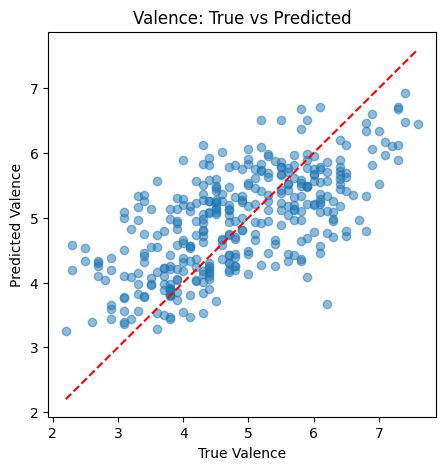

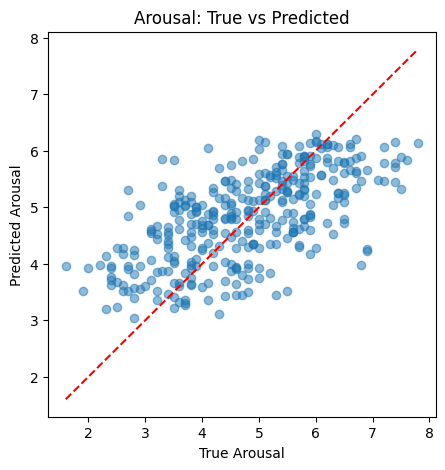

In [16]:
# ========== MAIN ==========

def main():
    X, y = prepare_dataset(AUDIO_DIR, ANNOTATION_CSV)
    print("Feature matrix X shape:", X.shape)
    print("Label matrix y shape:", y.shape)
    model, (X_test, y_test, y_pred) = train_and_evaluate(X, y)
    
    # (Optionally) save the model, or inspect predictions
    # For example, save via joblib
    save_model(model)
        
    # Quick scatter plot (optional)
    try:
        import matplotlib.pyplot as plt
        # plot true vs predicted for valence
        plt.figure(figsize=(5,5))
        plt.scatter(y_test[:, 0], y_pred[:, 0], alpha=0.5)
        plt.xlabel("True Valence")
        plt.ylabel("Predicted Valence")
        plt.title("Valence: True vs Predicted")
        plt.plot([min(y_test[:, 0]), max(y_test[:, 0])],
                 [min(y_test[:, 0]), max(y_test[:, 0])], 'r--')
        plt.show()
        # similarly for arousal
        plt.figure(figsize=(5,5))
        plt.scatter(y_test[:, 1], y_pred[:, 1], alpha=0.5)
        plt.xlabel("True Arousal")
        plt.ylabel("Predicted Arousal")
        plt.title("Arousal: True vs Predicted")
        plt.plot([min(y_test[:, 1]), max(y_test[:, 1])],
                 [min(y_test[:, 1]), max(y_test[:, 1])], 'r--')
        plt.show()
    except ImportError:
        pass
#audio=r"C:\Users\aksha\DEAM\DEAM_audio\MEMD_audio\2.mp3"
#print(extract_features(audio))
if __name__ == "__main__":
    main()